# Visualizing Wittmann Tours Embeddings

The goal of this notebook is to visualize the embeddings for the [Wittmann-Tours.de](https://wittmann-tours.de) blog the same way as described in my [embeddings notebook](10-embeddings.ipynb) / [embeddings blog post](https://chrwittm.github.io/posts/2024-03-15-embeddings/). The example is tailored to the blok post [Remembering the Wittmann Tours World Trip with RAG]() LINK

This notebook is not an explainer notebook, but I move quickly to get the job done.

## Initialize LLM

In [1]:
import sys
sys.path.append('../notebook_chat')

from notebook_chat import ChatMessages, Llama2ChatVersion2

from llama_cpp import Llama
llm = Llama(model_path="../models/Llama-2-7b-chat/llama-2-7b-chat.Q4_K_M.gguf", n_ctx=2048, verbose=False)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/Llama-2-7b-chat/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head

## Create Dataset

(skip this part if you just want to work on the Excel data, continue at "Loading Dataset")

I want to visualize the dataset by country. I do not have a good enough list so let's create one in Excel - and let's pre-populate the country with llama2

In [2]:
import pandas as pd

# Creating an empty DataFrame
df = pd.DataFrame()

In [3]:
import os
import glob

def get_blog_post_files(path):
    # Create a pattern to match all .md files in the directories under the base path
    pattern = os.path.join(path_to_blog, "**/*.md")

    # Use glob to find all files matching the pattern
    # The '**' pattern means "this directory and all subdirectories, recursively"
    # The '*.md' pattern means "all files ending with .md"
    file_list = glob.glob(pattern, recursive=True)

    # file_list now contains the full paths of all .md files
    return file_list

path_to_blog = "../wt-blogposts"
files = get_blog_post_files(path_to_blog)
files[0:3]

['../wt-blogposts/ritt-auf-paso-peruanos-im-colca-tal/index.md',
 '../wt-blogposts/tropical-treeclimbing-regenwald-auf-allen-etagen/index.md',
 '../wt-blogposts/hochland-kulinarisch-coca/index.md']

In [4]:
df['path'] = files

In [5]:
def get_blog_post_title(path_to_blogpost):
    # Remove the leading "../wt-blogposts/" and the trailing "/index.md"
    trimmed_path = path_to_blogpost.replace("../wt-blogposts/", "").replace("/index.md", "")
    
    # Replace "-" with spaces
    replaced_path = trimmed_path.replace("-", " ")
    
    # Capitalize the words
    title = replaced_path.title()
    
    return title

# Example
path_to_blogpost = "../wt-blogposts/drei-tage-im-masoalaregenwald/index.md"
title = get_blog_post_title(path_to_blogpost)
title

'Drei Tage Im Masoalaregenwald'

In [6]:
blog_post_titles = [get_blog_post_title(path_to_blogpost) for path_to_blogpost in files]
df['title'] = blog_post_titles
blog_post_titles[0:3]

['Ritt Auf Paso Peruanos Im Colca Tal',
 'Tropical Treeclimbing Regenwald Auf Allen Etagen',
 'Hochland Kulinarisch Coca']

In [11]:
def get_prompt(title):
    return ( f"Make an educated guess on which country a blog post is related to based on its title. The title is in German. Pick your answer from the list of countries, respond only with the name of the country"
             f"## Blog Post Title: "
             f"{title}"
             f"## List of Countries: "
             f"Japan, Myanmar, Cambodia, Hongkong, New Zealand, Australia, USA, Mexico, Belize, Ecuador, Peru, Bolivia, Brazil, Madagascar, Tanzania, Kenya, Jordan, Ethiopia, India, Iran, Germany"
             f"## Response format"
             f"Country"
)

In [12]:
get_prompt(blog_post_titles[0])

'Make an educated guess on which country a blog post is related to based on its title. The title is in German. Pick your answer from the list of countries, respond only with the name of the country## Blog Post Title: Ritt Auf Paso Peruanos Im Colca Tal## List of Countries: Japan, Myanmar, Cambodia, Hongkong, New Zealand, Australia, USA, Mexico, Belize, Ecuador, Peru, Bolivia, Brazil, Madagascar, Tanzania, Kenya, Jordan, Ethiopia, India, Iran, Germany## Response formatCountry'

In [16]:
def get_model_response(title):
    prompt = get_prompt(title)
    chat = Llama2ChatVersion2(llm, "Answer quick and fast, every token counts, Answer ONLY with the name of the country")
    return chat.prompt_llama2_without_printing(f"{prompt}")

In [17]:
get_model_response(blog_post_titles[0])

'  Based on the title of the blog post "Ritt Auf Paso Peruanos Im Colca Tal", I would guess that the country being referred to is Peru.'

In [18]:
model_responses = [get_model_response(title) for title in blog_post_titles]

In [19]:
def get_last_word(sentence):
    """
    Removes the period at the end of a sentence and returns the last word.

    Parameters:
    sentence (str): The sentence from which to extract the last word.

    Returns:
    str: The last word of the sentence.
    """
    # Remove the period at the end if it exists
    if sentence.endswith('.'):
        sentence = sentence[:-1]
    
    # Split the sentence into words and return the last word
    words = sentence.split()
    return words[-1] if words else ''

# Example usage
sentence = "This is a test sentence."
last_word = get_last_word(sentence)
print(f"The last word is: '{last_word}'")

The last word is: 'sentence'


In [20]:
countries = [get_last_word(model_response) for model_response in model_responses]

In [22]:
df['country'] = countries

In [21]:
countries[:10]

['Peru',
 'Brazil',
 'Bolivia',
 'India',
 'Ecuador',
 'Mexico',
 'Madagascar',
 'Mexico',
 'Brazil',
 'Brazil']

In [24]:
# Ensure you have the necessary library for working with .xlsx files
!pip install openpyxl

  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/6a/94/a59521de836ef0da54aaf50da6c4da8fb4072fb3053fa71f052fd9399e7a/openpyxl-3.1.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/96/c2/3dd434b0108730014f1b96fd286040dc3bcb70066346f7e01ec2ac95865f/et_xmlfile-1.1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 7.2 MB/s eta 0:00:00


In [25]:
import pandas as pd

# Export the DataFrame to an Excel file
df.to_excel("blogposts.xlsx", index=False)

print("DataFrame has been successfully exported to 'blogposts.xlsx'.")


DataFrame has been successfully exported to 'blogposts.xlsx'.


After exporting the Excel file, copied it to `[blogposts2.xlsx](./blogposts2.xlsx)` anf manually corrected the country column. Llama2 did an ok job, but I still had to correct around 20%.

I also added a file `[question.md](./question.md)` which contains the question to be visualized.

Additionally, I have added the country "Nearest" to visualize the question and the target blog post.

## Loading Dataset

Let's load the corrected/adjusted dataset and visualize it.

In [16]:
import pandas as pd

# Load the dataset from the Excel file
df = pd.read_excel('blogposts2.xlsx')

# Display the first few rows of the DataFrame to verify it's loaded correctly
print(df.head())

                                                path  \
0  ../wt-blogposts/ritt-auf-paso-peruanos-im-colc...   
1  ../wt-blogposts/tropical-treeclimbing-regenwal...   
2  ../wt-blogposts/hochland-kulinarisch-coca/inde...   
3  ../wt-blogposts/indien-kulinarisch-ein-land-vo...   
4  ../wt-blogposts/galapagos-die-verwunschenen-in...   

                                              title  country  
0               Ritt Auf Paso Peruanos Im Colca Tal     Peru  
1  Tropical Treeclimbing Regenwald Auf Allen Etagen   Brazil  
2                         Hochland Kulinarisch Coca  Bolivia  
3       Indien Kulinarisch Ein Land Von Vegetariern    India  
4                Galapagos Die Verwunschenen Inseln  Ecuador  


In [17]:
# Convert the desired column to a list
file_paths = df['path'].tolist()

print(file_paths[:3])
print(file_paths[-1])

['../wt-blogposts/ritt-auf-paso-peruanos-im-colca-tal/index.md', '../wt-blogposts/tropical-treeclimbing-regenwald-auf-allen-etagen/index.md', '../wt-blogposts/hochland-kulinarisch-coca/index.md']
../30-rag/question.md


In [18]:
def get_blog_post(path):
    with open(path, 'r') as file:
        content = file.read()
    return content

print(get_blog_post(file_paths[0])[:1000])    

---
title: 'Ritt auf Paso Peruanos im Colca Tal'
description: ""
published: 2018-11-05
redirect_from: 
            - https://wittmann-tours.de/ritt-auf-paso-peruanos-im-colca-tal/
categories: "Colca, Colca Canyon, Colca Tal, Inka, Paso, Paso Peruano, Peru, Peru, Pferde, Reiten, Viscacha"
hero: ./img/wp-content-uploads-2018-10-CW-20180514-083627-2590-1024x683.jpg
---
# Ritt auf Paso Peruanos im Colca Tal

In Peru ist man zu Recht sehr stolz auf die nationale Pferderasse des Landes, die [Paso Peruanos](https://de.wikipedia.org/wiki/Paso_Peruano). Ihre Besonderheit ist, dass sie eine spezielle, überaus bequeme Gangart haben, den [Paso Llano](https://de.wikipedia.org/wiki/Paso_Peruano#Gangmechanik), ähnlich dem Tölt der Islandpferde. Das Zuchtziel ("[Brio](https://de.wikipedia.org/wiki/Paso_Peruano#Interieur)") wird folgendermaßen definiert: "Eifrige Bereitwilligkeit kombiniert mit energischem Einsatz und ausdrucksvoller Präsentation". Auf diesen Prachtpferden wollten wir gerne reiten und 

In [19]:
from sentence_transformers import SentenceTransformer

#emb_model = SentenceTransformer("BAAI/bge-small-en-v1.5", device="mps")
emb_model = SentenceTransformer("BAAI/bge-m3", device="mps")


In [20]:
def get_text_embedding(text):
    return emb_model.encode(text, convert_to_tensor=True)

def get_blog_post_embedding(path):
    blog_post_text = get_blog_post(path)
    return get_text_embedding(blog_post_text)

In [21]:
get_blog_post_embedding(file_paths[0])[0:5]

tensor([-0.0269,  0.0095, -0.0356,  0.0271, -0.0061], device='mps:0')

In [22]:
blog_post_embeddings = [get_blog_post_embedding(file_path) for file_path in file_paths]
blog_post_embeddings[0].shape

torch.Size([1024])

In [23]:
countries = df['country'].tolist()
countries[:3]

['Peru', 'Brazil', 'Bolivia']

In [24]:
from sklearn.decomposition import PCA
import torch
import numpy as np

# Assuming blog_post_embeddings is a list of 1D tensors
# Convert all tensors to CPU and stack them into a 2D NumPy array
embeddings_array = np.stack([embedding.cpu().numpy() for embedding in blog_post_embeddings])

# Apply PCA to the 2D array to reduce to 2 dimensions
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# embeddings_2d now contains the 2D embeddings
print(embeddings_2d[0])


[-0.26867384  0.08774169]


In [25]:
country_colors = {
    "Japan": "#E6194B",  # Red
    "Myanmar": "#3CB44B",  # Green
    "Cambodia": "#FFD8B1",  # Apricot
    "Hongkong": "#4363D8",  # Blue
    "New Zealand": "#F58231",  # Orange
    "Australia": "#911EB4",  # Purple
    "USA": "#46F0F0",  # Cyan
    "Mexico": "#F032E6",  # Magenta
    "Belize": "#BCF60C",  # Lime
    "Ecuador": "#FABEBE",  # Pink
    "Peru": "#008080",  # Teal
    "Bolivia": "#E6BEFF",  # Lavender
    "Brazil": "#9A6324",  # Brown
    "Madagascar": "#FFFAC8",  # Beige
    "Tanzania": "#800000",  # Maroon
    "Kenya": "#AAFFC3",  # Mint
    "Iran": "#A9A9A9",  # Dark Gray
    "Jordan": "#808000",  # Olive
    "Ethiopia": "#FFE119",  # Yellow
    "India": "#5072A7",  # Light Navy
    "Germany": "#AAAAAA",  # Grey
    "Nearest": "#000000"  # Black
}


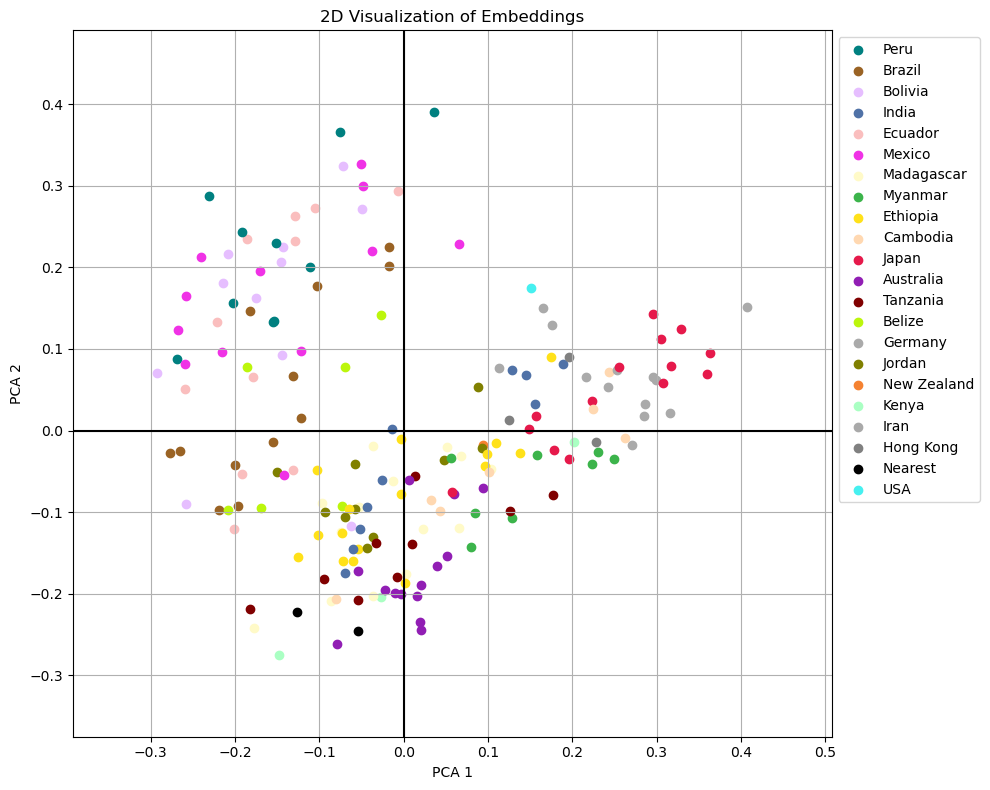

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Setup the plot
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D Visualization of Embeddings')

# Calculate bounds for the plot, if necessary
x_min, x_max = embeddings_2d[:, 0].min() - 0.1, embeddings_2d[:, 0].max() + 0.1
y_min, y_max = embeddings_2d[:, 1].min() - 0.1, embeddings_2d[:, 1].max() + 0.1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add grid
plt.grid(True)

# Draw the origin
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

# Plot each embedding
for i, (embedding, country) in enumerate(zip(embeddings_2d, countries)):
    color = country_colors.get(country, 'gray')  # Default to 'gray' if country not in dictionary
    ax.scatter(embedding[0], embedding[1], color=color, label=country if country not in ax.get_legend_handles_labels()[1] else "")

# Create a legend outside the plot area to the right
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()


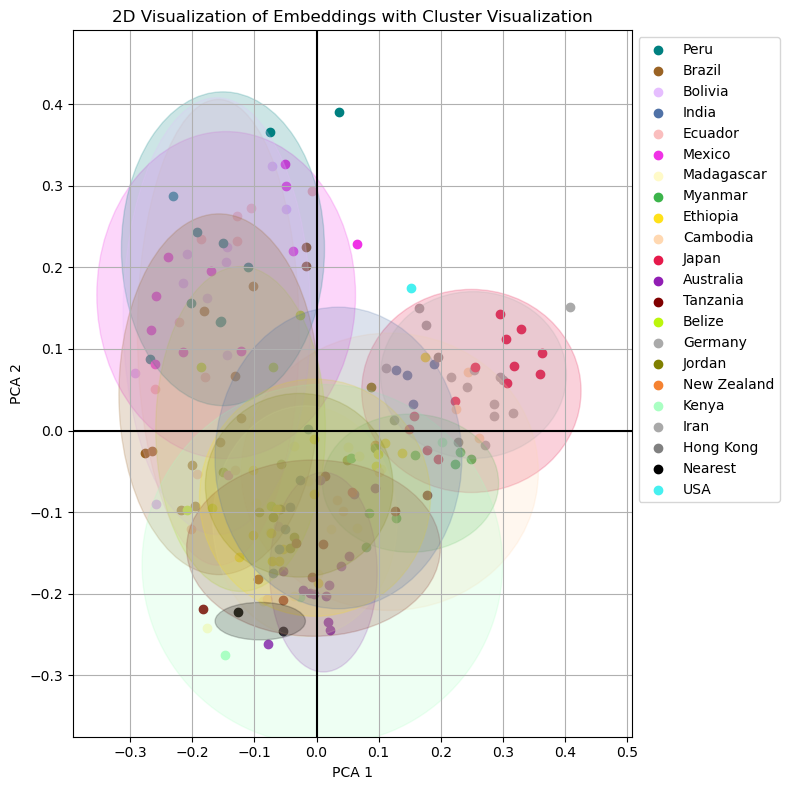

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Setup the plot
fig, ax = plt.subplots(figsize=(8, 8))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D Visualization of Embeddings with Cluster Visualization')

# Plot each embedding and calculate the bounds for plotting
x_min, x_max, y_min, y_max = float('inf'), -float('inf'), float('inf'), -float('inf')
for i, (embedding, country) in enumerate(zip(embeddings_2d, countries)):
    color = country_colors.get(country, 'gray')  # Default to 'gray' if country not in dictionary
    ax.scatter(embedding[0], embedding[1], color=color, label=country if country not in ax.get_legend_handles_labels()[1] else "")
    # Update plot bounds
    x_min, x_max = min(x_min, embedding[0]), max(x_max, embedding[0])
    y_min, y_max = min(y_min, embedding[1]), max(y_max, embedding[1])

# Adjust plot bounds
ax.set_xlim(x_min - 0.1, x_max + 0.1)
ax.set_ylim(y_min - 0.1, y_max + 0.1)

# Add grid and draw the origin
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

# Draw transparent bubbles for each group (country)
for country, color in country_colors.items():
    # Filter embeddings by country
    group_embeddings = np.array([embedding for embedding, country_ in zip(embeddings_2d, countries) if country == country_])
    if len(group_embeddings) > 0:
        centroid = np.mean(group_embeddings, axis=0)
        std_dev = np.std(group_embeddings, axis=0)
        ellipse = patches.Ellipse((centroid[0], centroid[1]), std_dev[0]*4, std_dev[1]*4, color=color, alpha=0.2)
        ax.add_patch(ellipse)

# Adjust legend to show unique countries
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
ax.legend(unique_handles, unique_labels, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()


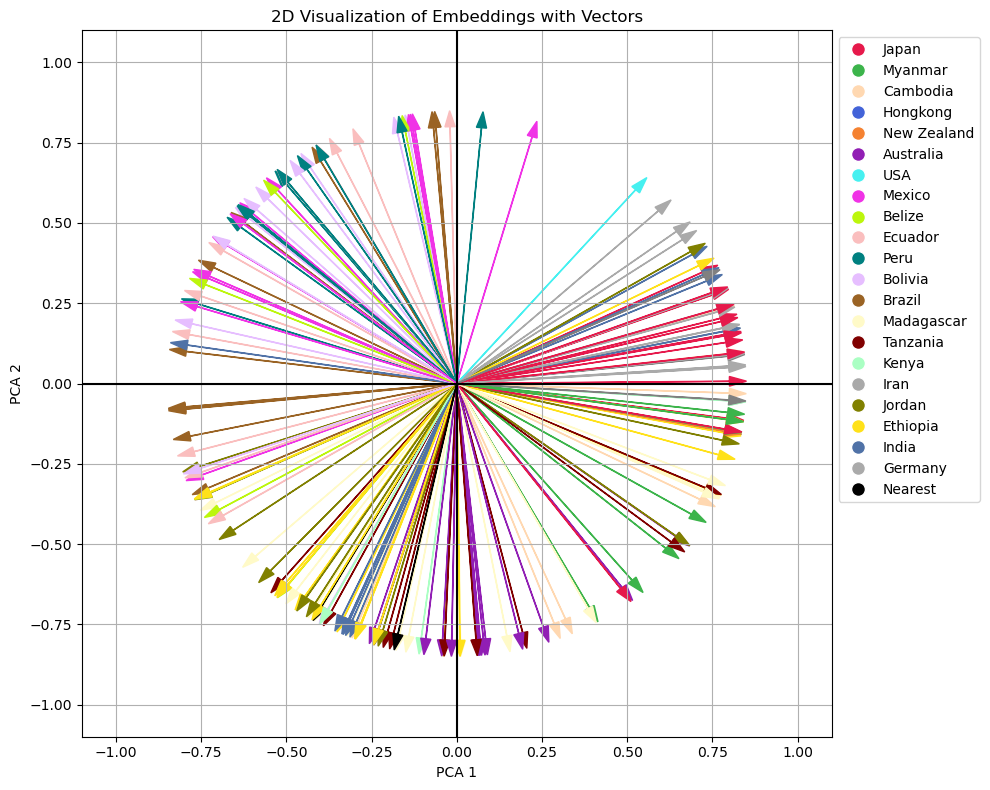

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D Visualization of Embeddings with Vectors')

# Set limits for the plot based on normalized vectors
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

# Add grid
plt.grid(True)

# Draw the origin
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

# Normalize vectors and plot
for i, (embedding, country) in enumerate(zip(embeddings_2d, countries)):
    # Normalize the vector
    norm = np.linalg.norm(embedding)
    if norm == 0:   # Avoid division by zero
        continue
    normalized_vector = embedding / norm
    
    # Calculate direction for the vector
    dx = normalized_vector[0]
    dy = normalized_vector[1]
    
    # Fixed length for all vectors
    length = 0.8
    
    # Set color based on country
    color = country_colors.get(country, 'gray')  # Default color if not found
    
    # Plot vector
    ax.arrow(0, 0, dx*length, dy*length, head_width=0.03, head_length=0.05, fc=color, ec=color)
    
    # Add text label for each country/vector
    #ax.text(dx*length, dy*length, country, fontsize=9)

# Optionally create a legend
# If your list of countries is large, you might want to customize this part
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=country,
                          markerfacecolor=color, markersize=10) for country, color in country_colors.items()]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


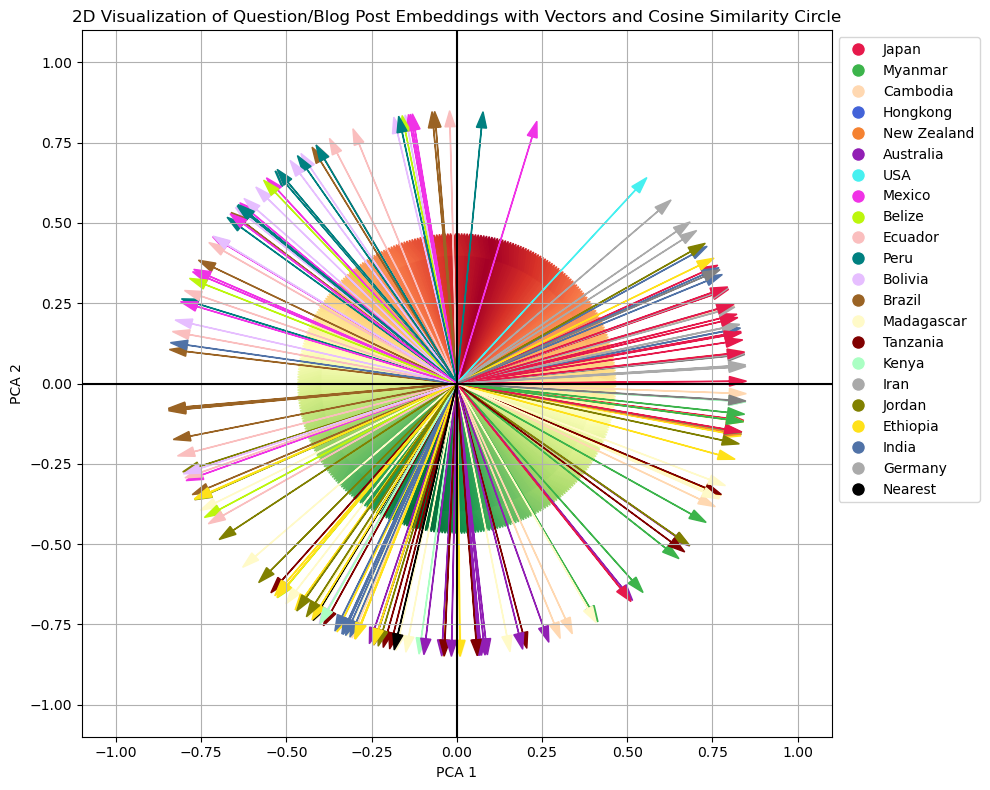

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D Visualization of Question/Blog Post Embeddings with Vectors and Cosine Similarity Circle')

# Normalize vectors and plot
norm_vectors = embeddings_2d / np.linalg.norm(embeddings_2d, axis=1, keepdims=True)
last_vector = norm_vectors[-1]  # The last vector in your normalized embeddings

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

# Add grid
plt.grid(True)

# Draw the origin
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

# Set up color mapping
norm = Normalize(vmin=0, vmax=180)
cmap = plt.get_cmap('RdYlGn')  # Green to Red color map
sm = ScalarMappable(norm=norm, cmap=cmap)

# Calculate the angle of the last vector
angle_last_vector = np.degrees(np.arctan2(last_vector[1], last_vector[0]))

# Draw colored circle
for angle in np.linspace(0, 2 * np.pi, 360):
    dx, dy = np.cos(angle), np.sin(angle)  # Unit vector in this direction
    angle_deg = np.degrees(angle)
    diff_angle = np.abs((angle_deg - angle_last_vector + 180) % 360 - 180)  # Difference in angle
    color = sm.to_rgba(180 - diff_angle)
    ax.arrow(0, 0, dx * 0.4, dy * 0.4, color=color, width=0.015)

# Plotting the vectors
for i, (embedding, country) in enumerate(zip(norm_vectors, countries)):
    color = country_colors.get(country, 'gray')  # Default color if not found
    ax.arrow(0, 0, embedding[0]*0.8, embedding[1]*0.8, head_width=0.03, head_length=0.05, fc=color, ec=color)

# Optionally create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=country,
                          markerfacecolor=color, markersize=10) for country, color in country_colors.items()]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
